In [3]:
%matplotlib inline

import os
import warnings
import collections
import time
from datetime import timedelta

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates

import plot_functions as pfn
import pandas as pd
import numpy as np
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH '] = '1'

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')

# show gpu status, fix memory growth
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:

    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "physical GPUs,", len(logical_gpus), "logical GPUs", logical_gpus)

    except RuntimeError as e:
        print(e)

print( 'tf version :', tf.__version__ )
print( 'tfp version:', tfp.__version__ )


1 physical GPUs, 1 logical GPUs [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
tf version : 2.1.0
tfp version: 0.9.0


In [5]:

from datetime import datetime, timedelta
import pprint

sys.path.append( os.path.abspath( '..\\td-ameritrade-python-api' ) )
from td.client import TDClient
from td.config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI, TD_ACCOUNT

# Create a new session
TDSession = TDClient(account_number = '870008897',
                     account_password = '',
                     consumer_id = 'GAIZW6FC8LMDK31OCB4Q4NDK7LI7TFF5',
                     redirect_uri = 'https://gnosko.obolary.com')

# Login to the session
TDSession.login()
print(TDSession)


<TDAmeritrade Client (logged_in = True, authorized = Authenticated)>


In [6]:

# Define the static arguments.
hist_symbol = 'GLD'
hist_needExtendedHoursData = True

# Define the dynamic arguments - I want 5 DAYS of historical 1-minute bars.
hist_periodType = 'year'
hist_period = 2
hist_frequencyType = 'daily'
hist_frequency = 1

# make the request
historical = TDSession.get_price_history(symbol=hist_symbol, periodType=hist_periodType,
                                                  period=hist_period, frequencyType=hist_frequencyType,
                                                  frequency=hist_frequency, needExtendedHoursData=hist_needExtendedHoursData)


In [7]:
dataset = pd.DataFrame.from_dict( historical['candles'] )
dataset = dataset.set_index( ['datetime'] )
dataset.index = pd.to_datetime(dataset.index,unit='ms')
print(dataset.head())


open      high       low   close    volume
datetime                                                         
2018-04-17 05:00:00  127.02  127.7800  127.0010  127.75   4184077
2018-04-18 05:00:00  128.32  128.5400  127.7510  127.85   6755575
2018-04-19 05:00:00  127.81  127.8839  127.1300  127.60   8736103
2018-04-20 05:00:00  126.69  126.9700  126.5500  126.63  10403128
2018-04-23 05:00:00  125.62  125.7600  125.3412  125.62   6921519


In [8]:
dataset['close'].size

505

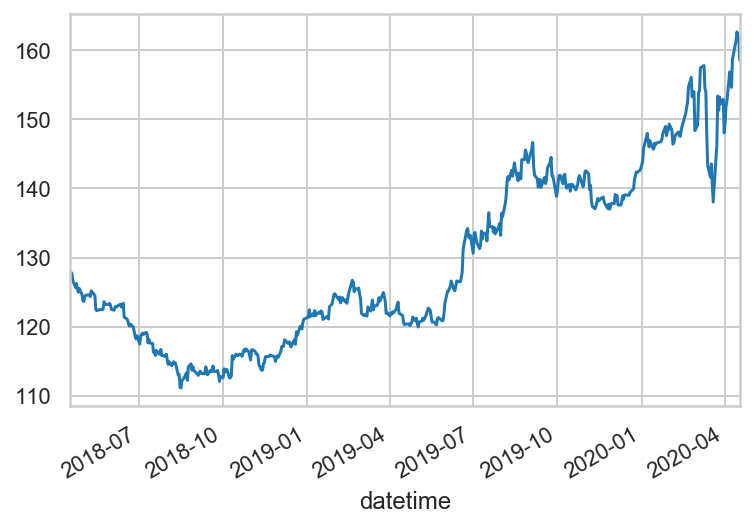

In [9]:
dataset['close'].plot()

In [65]:
num_forecast_steps=20

space = 10
window = dataset['close'].size - space

close  = dataset['close'][-window:]
volume = dataset['volume'][-window:]
dates  = dataset.index[-window:]


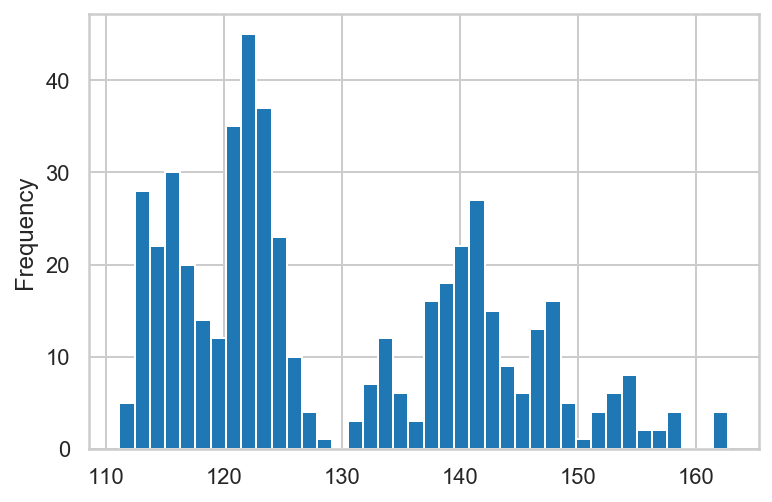

In [66]:
close.plot.hist(bins=40)

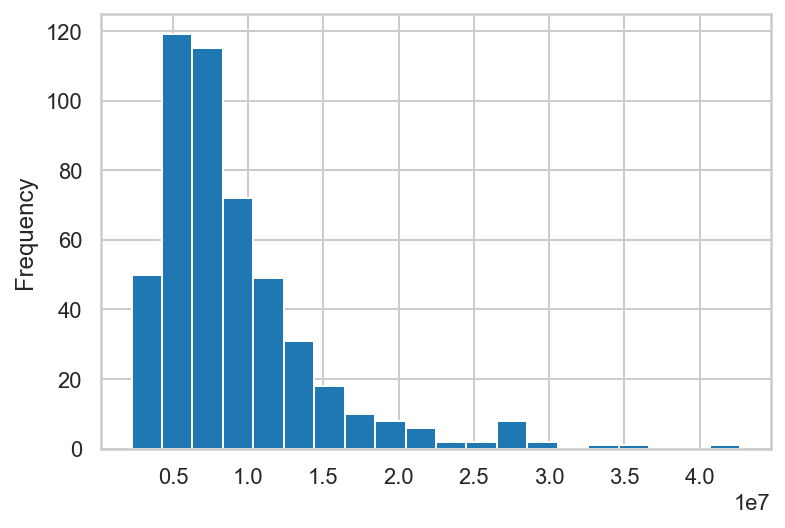

In [67]:
volume.plot.hist(bins=20)

datetime
2018-05-01 05:00:00   -0.186179
2018-05-02 05:00:00   -0.177944
2018-05-03 05:00:00   -0.627435
2018-05-04 05:00:00   -0.435771
2018-05-07 05:00:00   -0.984893
Name: volume, dtype: float64

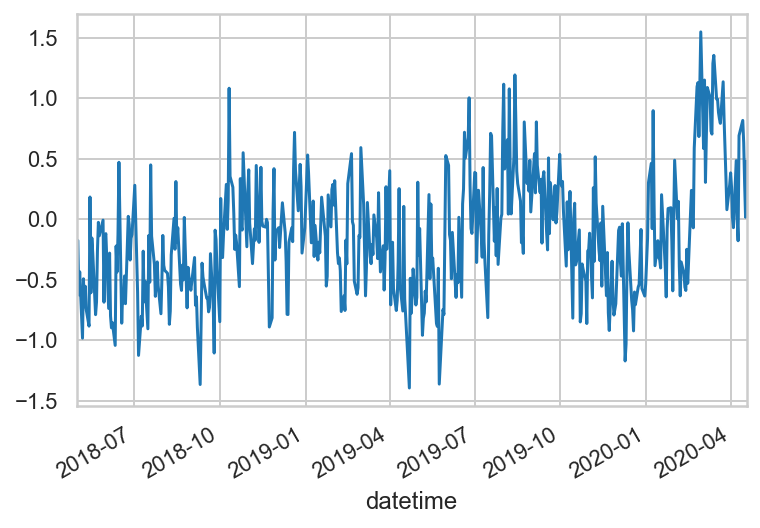

In [68]:
ds=np.log( volume / volume.mean() )
ds.plot()
ds.head()

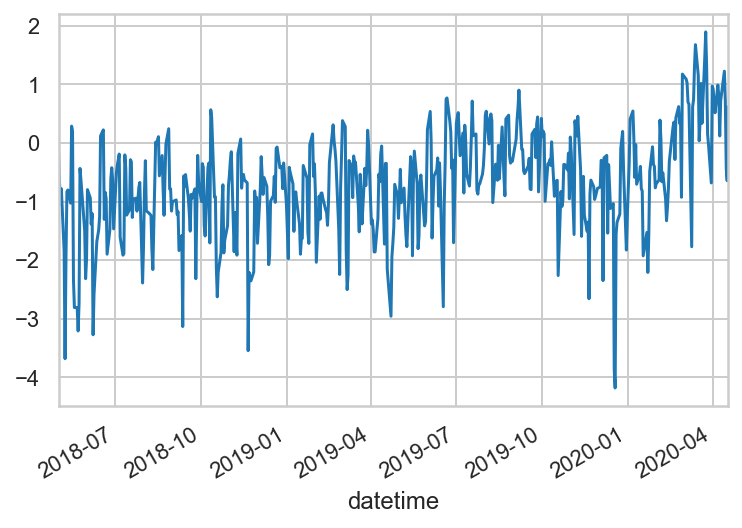

In [74]:
zs=np.log( dataset['close'].rolling(3).std() )[-window:]
zs.head()
zs.plot()


In [104]:
def build_model( observed_time_series, observed_volume, observed_rolling_std ):
  
  baseline = sts.SemiLocalLinearTrend( 
      observed_time_series=observed_time_series, 
      name='baseline' 
  )
  weekly = sts.Seasonal( 
      num_seasons=52,
      num_steps_per_season=5, 
      observed_time_series=observed_time_series,
      name='weekly'
  )
  daily = sts.Seasonal( 
      num_seasons=5,
      num_steps_per_season=1, 
      observed_time_series=observed_time_series,
      name='daily'
  )
  residual = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series, 
      name='residual'
  )
    
  model = sts.Sum( [ baseline, weekly, daily, residual ], observed_time_series=observed_time_series )
  return model

In [105]:
close_model = build_model( close, tf.cast(ds,dtype=tf.float64), tf.cast(zs,dtype=tf.float64) )
variational_posteriors = sts.build_factored_surrogate_posterior( model=close_model )


In [106]:
%%time

num_variational_steps=int(100)
optimizer = tf.optimizers.Adam( learning_rate=0.001 )

def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior( 
        target_log_prob_fn = close_model.joint_log_prob( observed_time_series = close ),
        surrogate_posterior = variational_posteriors,
        optimizer = optimizer,
        num_steps = num_variational_steps )
    return elbo_loss_curve

def train_with_hmc():
    q_samples,kernel_results = tfp.sts.fit_with_hmc(
        model=close_model,
        observed_time_series=close,
        num_variational_steps=num_variational_steps,
        variational_optimizer=optimizer,
        variational_sample_size=1
    )
    print("acceptance rate: {}".format(np.mean(kernel_results.inner_results.inner_results.is_accepted, axis=0)))
    return q_samples

is_train_with_vi=False
if is_train_with_vi:
    
    elbo_loss_curve = train()
    q_samples = variational_posteriors.sample( 60 )

else:
    
    q_samples = train_with_hmc()
        

acceptance rate: 0.89
Wall time: 1h 26min 40s


In [107]:
if is_train_with_vi:
    
    plt.plot( elbo_loss_curve )


In [108]:
print( 'Inferred parameters')
if is_train_with_vi:
    for param in close_model.parameters:
        print( "{}: {} +- {}".format( param.name, np.mean(q_samples[param.name], axis=0), np.std(q_samples[param.name], axis=0)))
else:
    for index,param in enumerate(close_model.parameters):
        print( "{}: {} +- {}".format( param.name, np.mean(q_samples[index], axis=0), np.std(q_samples[index], axis=0)))
        

Inferred parameters
observation_noise_scale: 0.01548600574311205 +- 0.020593071341374124
baseline/_level_scale: 0.77049743137221 +- 0.3063290019664944
baseline/_slope_mean: 1.839419811567955 +- 5.809547893865912
baseline/_slope_scale: 0.01975706466634434 +- 0.01179569685603587
baseline/_autoregressive_coef: 0.9990665801594679 +- 0.0014574706573060405
weekly/_drift_scale: 0.021985245438953655 +- 0.06697852850849183
daily/_drift_scale: 0.01643077421349731 +- 0.011202604834326125
residual/_coefficients: [0.8859955] +- [0.08347859]
residual/_level_scale: 0.7619587845338086 +- 0.3713908240658669


In [109]:
%%time 

close_forecast_dist = sts.forecast( 
    close_model, 
    observed_time_series=close,
    parameter_samples=q_samples, 
    num_steps_forecast=num_forecast_steps 
)


Wall time: 9.43 s


In [110]:
num_samples = 240
close_forecast_mean, close_forecast_scale, close_forecast_samples = (
    close_forecast_dist.mean().numpy()[...,0],
    close_forecast_dist.stddev().numpy()[...,0],
    close_forecast_dist.sample(num_samples).numpy()[...,0]
)

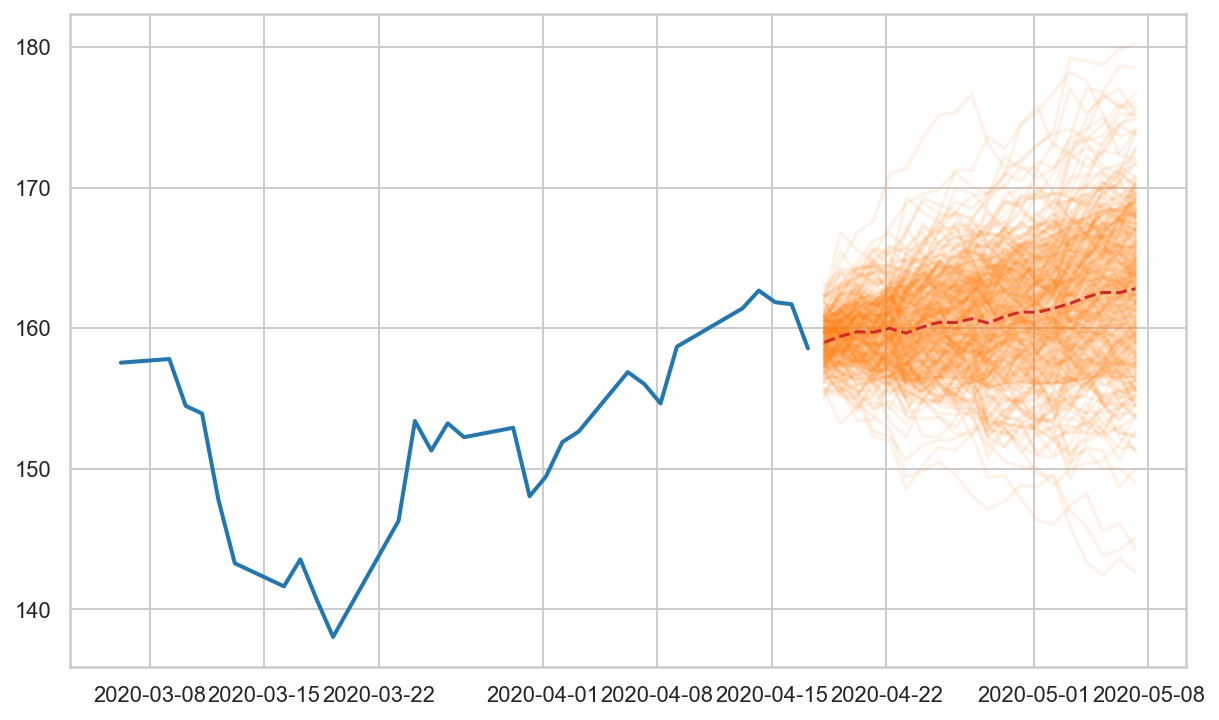

In [123]:
end = 30

colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[3]

fig = plt.figure(figsize=(10,6))
az  = fig.add_subplot(1,1,1)
_ = az.plot( dates[-end:], close[-end:], lw=2, color=c1, label='ground truth' )

forecast_dates = pd.date_range( start=dates[-1] + timedelta( days=1 ), end=dates[-1] + timedelta( days=num_forecast_steps ) )
_ = az.plot( forecast_dates, close_forecast_samples.T, color=c2, alpha=0.1 )

_ = az.plot( forecast_dates, close_forecast_mean, ls='--', color=c3, label='forecast' )
_ = az.fill_between( forecast_dates, close_forecast_mean - 1 * close_forecast_scale, close_forecast_mean + 1 * close_forecast_scale, color=c2, alpha=0.2 )


In [112]:
close_forecast_mean[-1]

162.81486679749563

In [113]:
%%time

component_dists=sts.decompose_by_component( 
    close_model, 
    observed_time_series=close, 
    parameter_samples=q_samples
)

close_component_means, close_component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)


Wall time: 19.3 s


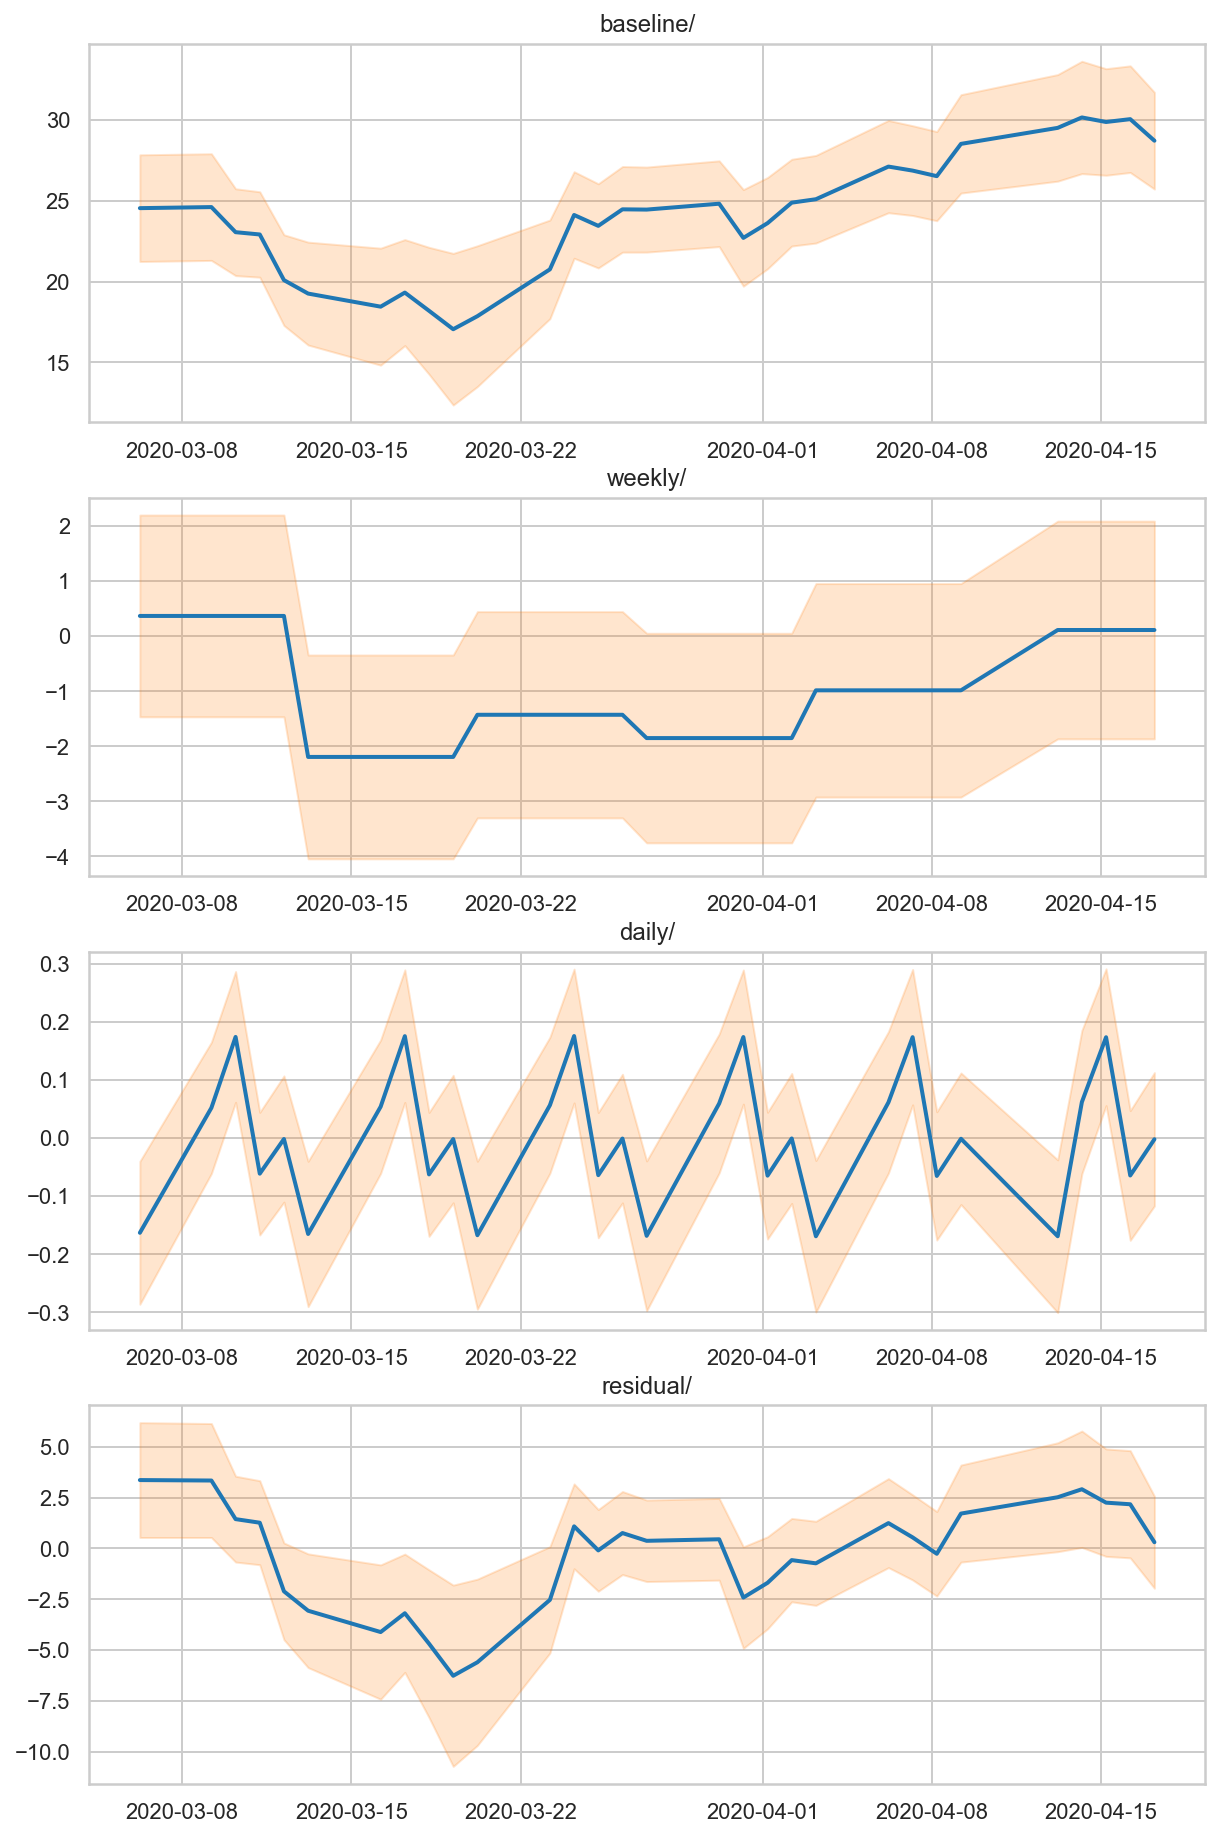

In [114]:
end = end
component_means = close_component_means
component_stddevs = close_component_stddevs

num_components = len(component_means)
fig = plt.figure( figsize=(10, 4*num_components) )
for i, component_name in enumerate( component_means.keys() ):

    component_mean = component_means[ component_name ][-end:]
    component_stddev = component_stddevs[ component_name ][-end:]

    az = fig.add_subplot( num_components, 1, 1+i )
    _ = az.plot( dates[-end:], component_mean, lw=2 )
    _ = az.fill_between( dates[-end:], component_mean - 1*component_stddev, component_mean + 1*component_stddev, color=c2, alpha=0.2 )

    az.set_title( component_name )

In [115]:
%%time

forecast_component_dists = sts.decompose_forecast_by_component(
    close_model,
    forecast_dist=close_forecast_dist,
    parameter_samples=q_samples
)
forecast_component_means, forecast_component_stddevs = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


Wall time: 809 ms


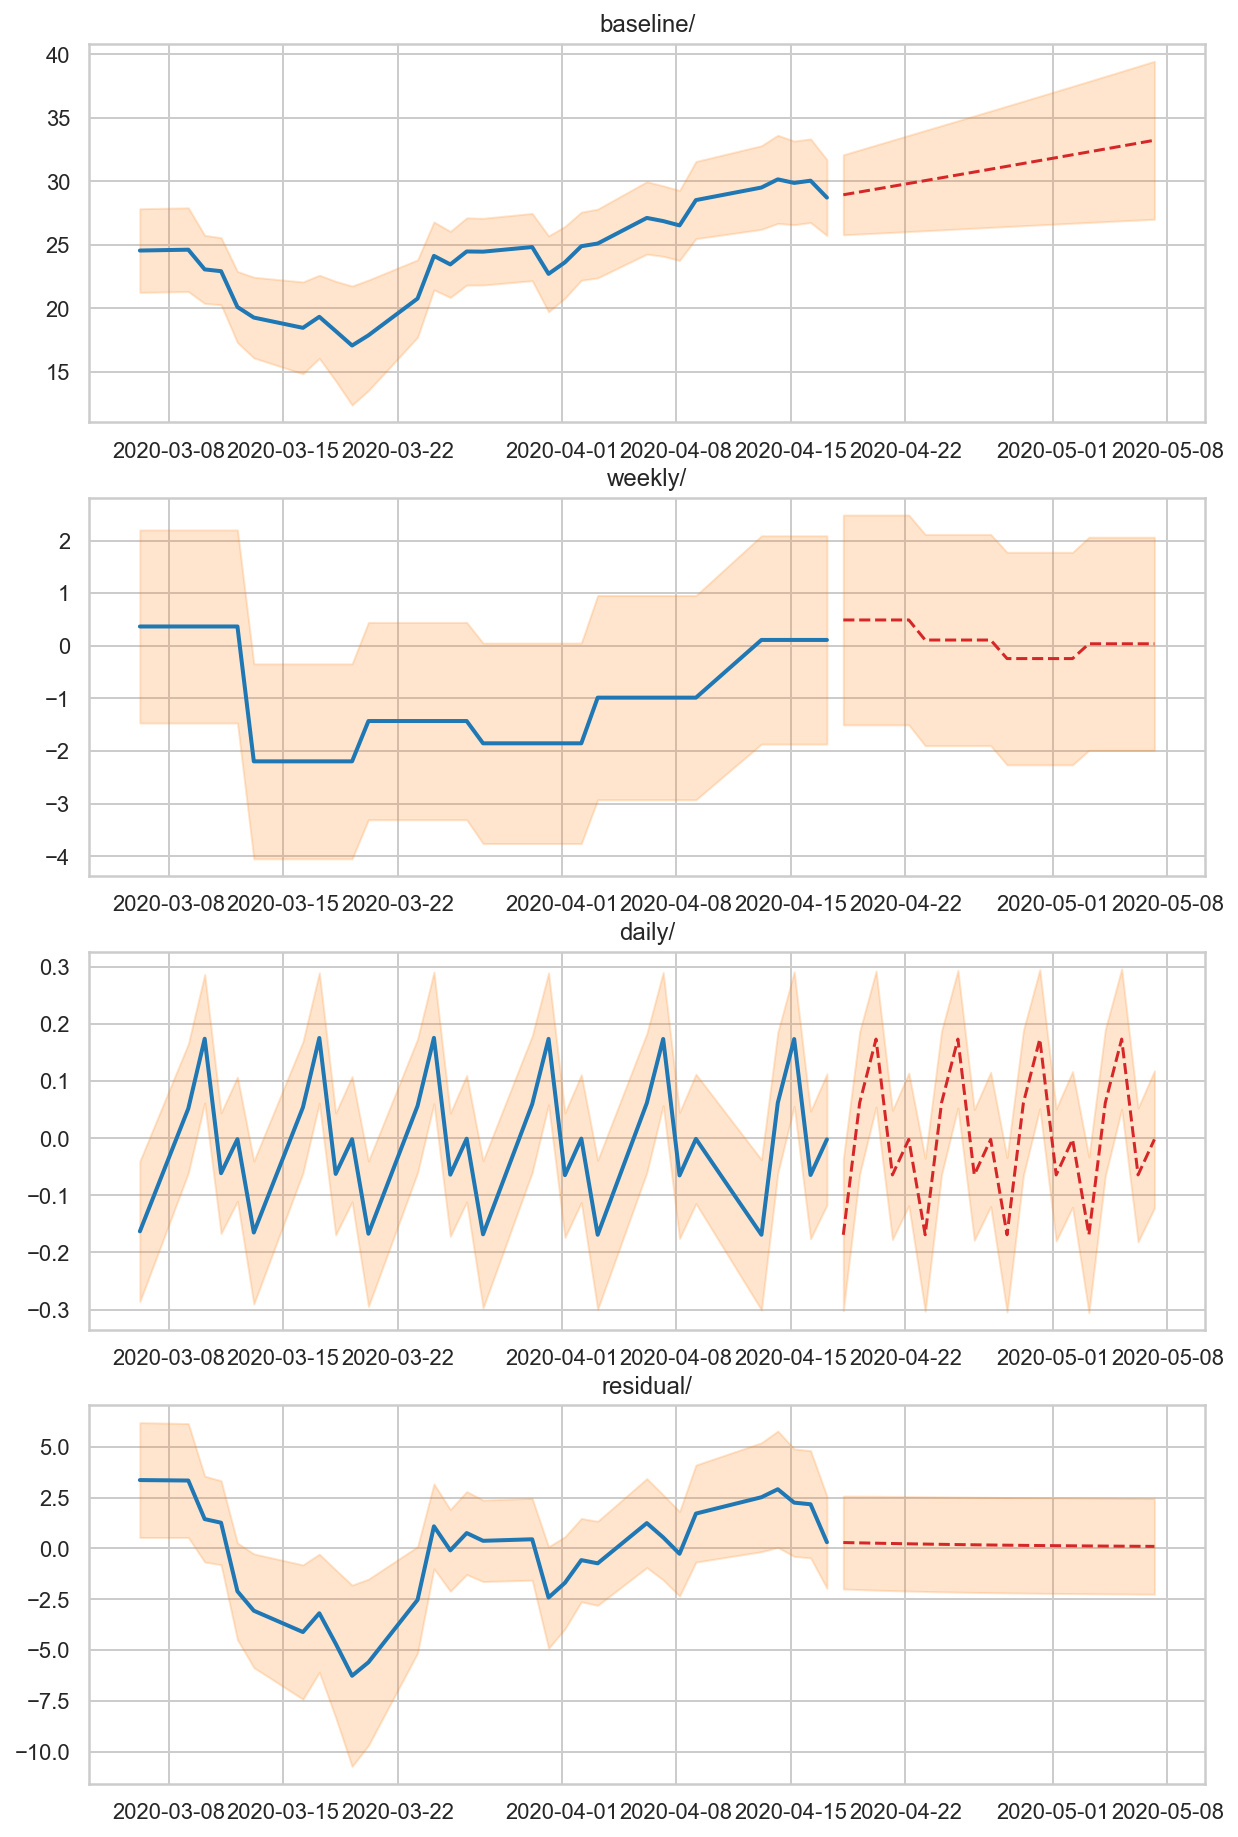

In [118]:
end = end
component_means = close_component_means
component_stddevs = close_component_stddevs

forecast_means = forecast_component_means
forecast_stddevs = forecast_component_stddevs
forecast_dates = pd.date_range( start=dates[-1] + timedelta( days=1 ), end=dates[-1] + timedelta( days=num_forecast_steps ) )

num_components = len(component_means)
fig = plt.figure( figsize=(10, 4*num_components) )
for i, component_name in enumerate( component_means.keys() ):

    component_mean = component_means[ component_name ][-end:]
    component_stddev = component_stddevs[ component_name ][-end:]
    forecast_mean = forecast_means[ component_name ]
    forecast_stddev = forecast_stddevs[ component_name ]

    az = fig.add_subplot( num_components, 1, 1+i )
    _ = az.plot( dates[-end:], component_mean, lw=2 )
    _ = az.fill_between( dates[-end:], component_mean - 1*component_stddev, component_mean + 1*component_stddev, color=c2, alpha=0.2 )

    _ = az.plot( forecast_dates, forecast_mean, ls='--', color=c3, label='forecast' )
    _ = az.fill_between( forecast_dates, forecast_mean - 1 * forecast_stddev, forecast_mean + 1 * forecast_stddev, color=c2, alpha=0.2 )

    az.set_title( component_name )

